# Self Guided DIP Implementation for LGE Data (Studies III and IV):

### Import libraries and utilities:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
import torch.optim as optim
import torch.fft as fft
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
# from tqdm.notebook import tqdm
import sigpy as sp
# import sigpy.mri as mr
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
import pickle
import glob
# from models import skip
#from DIP_UNET_models.skip import skip
from models import UNet, FullUNet, MediumUNet, OneLayerUNet, ExtraDeepUNet, SuperDeepUNet
from utils.common_utils import *
from utils.fftc import * # ra: added the pytorch fft routine from fastmri


/home/ahmad.sultan/.conda/envs/DISCUS-Sultan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Check device:

In [2]:
# check available hardware:
def list_cuda_devices():
    if torch.cuda.is_available():
        num_devices = torch.cuda.device_count()
        print(f"Number of available CUDA devices: {num_devices}")
        for i in range(num_devices):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / 1024 ** 2:.2f} MB")
            print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / 1024 ** 2:.2f} MB")
            print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB")
    else:
        print("CUDA is not available.")

list_cuda_devices()

Number of available CUDA devices: 2
Device 0: NVIDIA GeForce RTX 4090
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Total Memory: 24217.31 MB
Device 1: NVIDIA GeForce RTX 4090
  Memory Allocated: 0.00 MB
  Memory Cached: 0.00 MB
  Total Memory: 24217.31 MB


### define additional utilities:

In [3]:
## for multi-coil data:
def fft_with_shifts(img):
    return fft.fftshift(fft.fft2(fft.ifftshift(img), norm='ortho'))

def ifft_with_shifts(ksp):
    return fft.fftshift(fft.ifft2(fft.ifftshift(ksp), norm='ortho'))

def ksp_and_mps_to_gt(ksp, mps): # multi-coil kspace and sensitivity maps to ground truth image
    gt = mps.conj() * ifft_with_shifts(ksp)
    gt = torch.sum(gt, axis=0) # axis=0 is the coil dim.
    return gt

def mps_and_gt_to_ksp(mps, gt): # maps and ground truth image to multi-coil kspace
    ksp = fft_with_shifts(mps * gt)
    return ksp


def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]

# NMSE and SSIM functions:
def compute_nmse(x, xHat): # for a batch of images: assuming 1st dimension to be Batch dimension
    nmse = 10*torch.log10(torch.mean(torch.sum((x-xHat)**2, dim=(-1,-2)) / torch.sum(x**2, dim=(-1,-2))))
    return nmse

# def compute_ssim(x, xHat):
#     batch_size = x.shape[0]
#     ssim = torch.zeros(batch_size)
#     for i in range(batch_size): # over batch dimension
#         ssim[i] = ssm(torch_to_np(x[i,:,:]), torch_to_np(xHat[i,:,:]), data_range=(xHat[i,:,:].max()-xHat[i,:,:].min()).item())
#     return torch.mean(ssim) # average over batch dimension

## Choose parameters and dataset 

In [10]:
#parameters:
FS=1
R=2
nt= 32 # choose num of frames to run

# a list of all patient file names: ["SJK_SAX_BASE", "SJK_SAX_MOCO", "SJK_3CH", "JBH_3CH", "JGR_3CH", "GRH_3CH", "AT_3CH", "JBH_3CH"]
id="JBH_3CH"  # choose one of the 8 preprocessed patients 

In [11]:
## based on ID above, data file names are selected automatically. You can specify yours file too.
if not FS:
    R=5.069307
# # arbitrary id
# id = "JB_3CH" #'SJK_SAX_MOCO' #SJK_SAX_BASE # SAX # 2CH # 3CH
crop_set = 0.9
if id[0:3]=="SJK":
   subject = "20230125_CS_LGE_SKJ/" #"20230125_CS_LGE_SKJ/"
   if not FS:
      if id=="SJK_SAX_BASE":
         file = "/meas_MID00257_FID117434_SS_TRUFI_CS_PSIR_SAX_BASE_SAX/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH
      elif id=="SJK_SAX_MOCO":
         file = "/meas_MID00258_FID117435_SS_TRUFI_CS_PSIR_SAX_SAX_MOCO_54_6/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH
      elif id=="SJK_3CH":
         file = "/meas_MID00259_FID117436_SS_TRUFI_CS_PSIR_SAX_3CH/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH

   else:
      if id=="SJK_SAX_BASE":
         file = "/meas_MID00260_FID117437_SS_TRUFI_PSIR_SAX_FULL_SAMP_BASE_SAX/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH
      elif id=="SJK_SAX_MOCO":
         file = "/meas_MID00261_FID117438_SS_TRUFI_PSIR_SAX_FULL_SAMP_SAX_MOCO_54_6/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH
      elif id=="SJK_3CH":
         file = "/meas_MID00262_FID117439_SS_TRUFI_PSIR_SAX_FULL_SAMP_3CH/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH

elif id[0:3]=="JBH":
   subject = "20230118_CS_LGE_JB/" #"20230125_CS_LGE_SKJ/"
   if not FS:
      if id=="JBH_3CH":
         crop_set=0.8
         file = "/meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH
   else:
      if id=="JBH_3CH":
         file = "/meas_MID00383_FID115210_SS_TRUFI_PSIR_3CH_FULL_SAMP/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH

elif id[0:3]=="JGR":
   subject = "20230308_CS_LGE_JGR/" #"20230125_CS_LGE_SKJ/"
   if not FS:
      crop_set = 0.6
      R=6.336634
      if id=="JGR_3CH":
         file = "/meas_MID00097_FID134147_SS_TRUFI_CS_PSIR_3CH/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH
      elif id=="JGR_SAX_BASE":
         file = "/meas_MID00096_FID134146_SS_TRUFI_CS_PSIR_BASE_SAX/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH

elif id[0:3]=="GRH":
   subject = "20230118_CS_LGE_GR/" #"20230125_CS_LGE_SKJ/"
   if not FS:
      crop_set=0.8
      R=7.603960
      if id=="GRH_3CH":
         file = "/meas_MID00488_FID115315_SS_TRUFI_CS_PSIR_3CH/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH

elif id[0:2]=="AT":
   subject = "20230816_CS_LGE_AT/" #"20230125_CS_LGE_SKJ/"
   if not FS:
      if id=="AT_3CH":
         file = "/meas_MID00400_FID199583_SS_TRUFI_CS_PSIR_3_CH_SLICE_54_5/" #meas_MID00381_FID115208_SS_TRUFI_CS_PSIR_3CH

folder = ""#"new sen cc maps/" # for new sen cc maps
data_path = "../data/LGE/"+subject +folder+file # for new sen cc maps: folder
# data_path0 = data_path+"set1/"
# set=0 # set=0 for T1 (with contrast)
if FS:
    data_path_r = data_path + "R%d/"%R
else:
    data_path_r = data_path
# else: # US case
# crop_set= 0.9 #[0.2,0.3]
set=0
crop=crop_set #[set]
## display
gm = [1, 0.3, 0.7] # gamma correction for display
g=1
mps = [plt.cm.Greys_r, 'gray']
epsilon = 1e-10


In [12]:

# read US data:
ksp = np.load(data_path_r+"yu" +"_R_%f"%R+"_set_%d"%set+".npy")
print(ksp.shape, ksp.dtype)
(N,Nc,Nx,Ny) = np.shape(ksp)
n = (Nx, Ny)

# R=2
msk = np.load(data_path_r+"mask_R_%f"%R+".npy")
maps = np.load(data_path_r+"ESPIRiT_crop_%f"%crop+ '_R_%f'%R+"_set_%d"%set +".npy")
sen_msk = np.load(data_path_r+"th_sen_map_crop_%f"%crop+'_R_%f'%R+"_set_%d"%set+".npy")
cc_maps_sens = np.load(data_path+"sen_cc_map"+".npy")
if FS:
    img = np.load(data_path+"xRef_N_%d"%N+"_set_%d"%set+".npy")

ku = complex_to_real_plus_imag_4d(ksp)
samp = msk
sen = complex_to_real_plus_imag_4d(np.expand_dims(maps,axis=0)) * cc_maps_sens
sen_c = maps * cc_maps_sens # corrected sen maps

if FS:
    m = complex_to_real_plus_imag_3d(img)


(32, 8, 160, 96) complex128


FileNotFoundError: [Errno 2] No such file or directory: '../data/LGE/20230118_CS_LGE_JB//meas_MID00383_FID115210_SS_TRUFI_PSIR_3CH_FULL_SAMP/R2/ESPIRiT_crop_0.900000_R_2.000000_set_0.npy'

### Network:

In [11]:
# network weights initialization:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    # print('Initialized network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


In [14]:
PLOT = 0
gm=0.5
sv_SSDIP=0
num_epochs=2000
show_every=200
learning_rate = 3e-4
alpha = 1e-3#s2 # strength of denoiser regularization
# requires tuning: free parameter
# show_every = 50




## Select frame to reconstruct:


frame  1
SSIM:  0.9806898790384574
NMSE:  -24.341642078638053


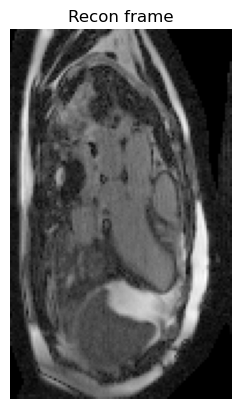


frame  2
SSIM:  0.981731869742875
NMSE:  -24.794129700335557


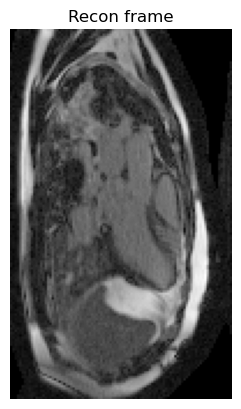


frame  3
SSIM:  0.9794384113168341
NMSE:  -23.62833769344818


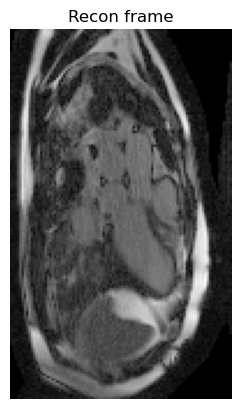


frame  4
SSIM:  0.9787612769772244
NMSE:  -24.2376440324808


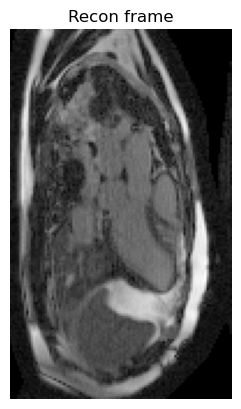


frame  5
SSIM:  0.9798558068410476
NMSE:  -24.57742864685631


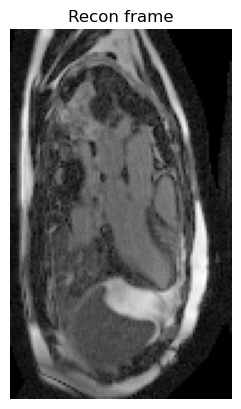


frame  6
SSIM:  0.980755905388517
NMSE:  -24.544476210211265


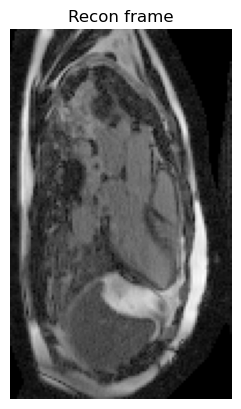


frame  7
SSIM:  0.9803608136393573
NMSE:  -24.223019093195525


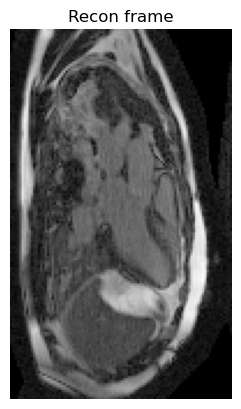


frame  8
SSIM:  0.9806073026603793
NMSE:  -24.688830790283518


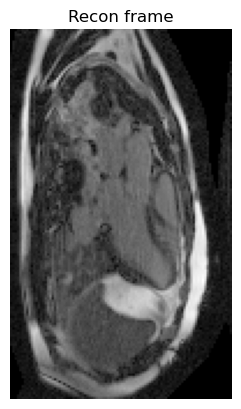


frame  9
SSIM:  0.9804859539952859
NMSE:  -24.505149162562123


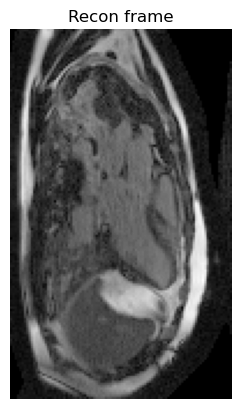


frame  10
SSIM:  0.9824391416301467
NMSE:  -24.869753977816206


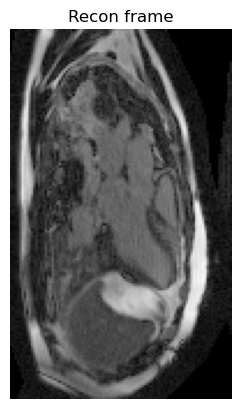


frame  11
SSIM:  0.9781960452109866
NMSE:  -24.084962166511584


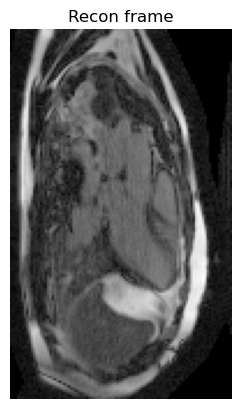


frame  12
SSIM:  0.9794033949750904
NMSE:  -24.30688134300749


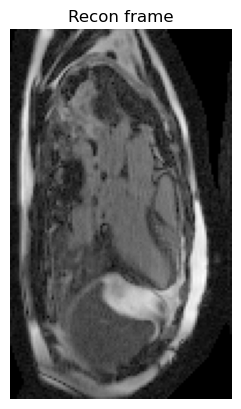


frame  13
SSIM:  0.980003706571563
NMSE:  -24.322573452736687


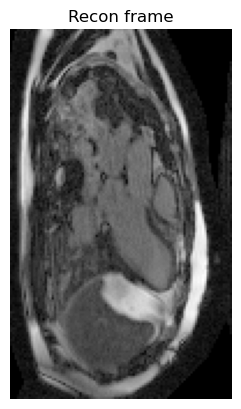


frame  14
SSIM:  0.9800645327600178
NMSE:  -24.516810013999986


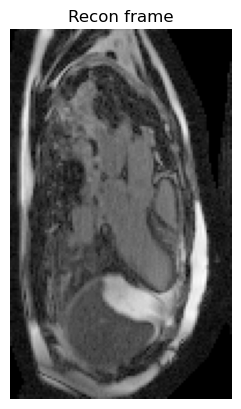


frame  15
SSIM:  0.9787513748950435
NMSE:  -24.154976834509565


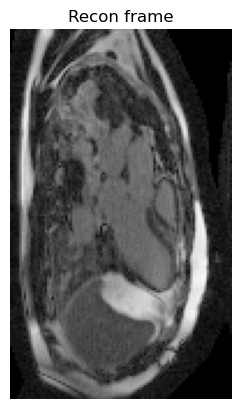


frame  16
SSIM:  0.9795980940117548
NMSE:  -24.391420282843615


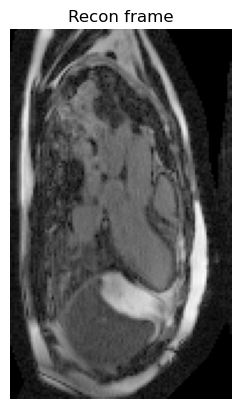


frame  17
SSIM:  0.9787148888367657
NMSE:  -24.109292547018327


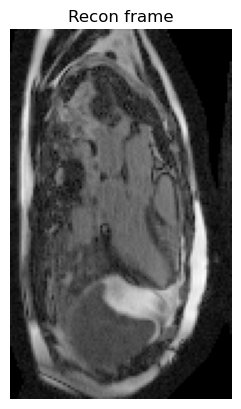


frame  18
SSIM:  0.9800549979277031
NMSE:  -24.469576831497577


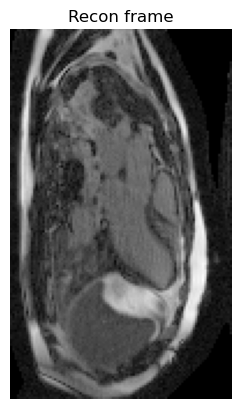


frame  19
SSIM:  0.979667131335549
NMSE:  -24.390592493483002


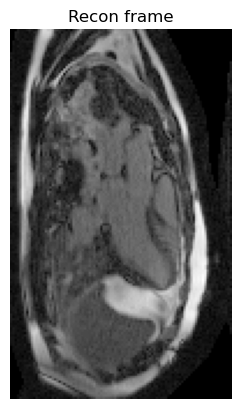


frame  20
SSIM:  0.9800057950405245
NMSE:  -24.511015925806735


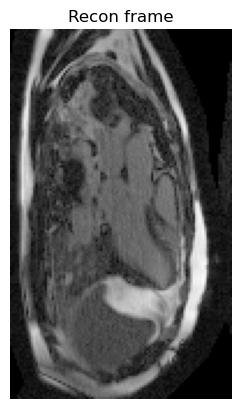


frame  21
SSIM:  0.9793568954182438
NMSE:  -24.41727548193016


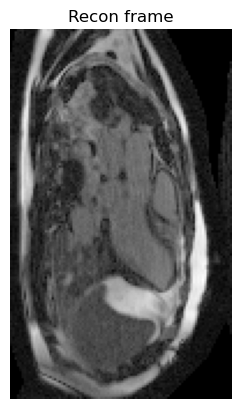


frame  22
SSIM:  0.9801925482889977
NMSE:  -24.428133730827337


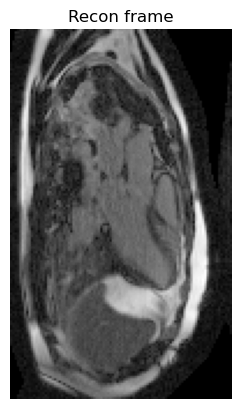


frame  23
SSIM:  0.9807682558339864
NMSE:  -24.22544553135338


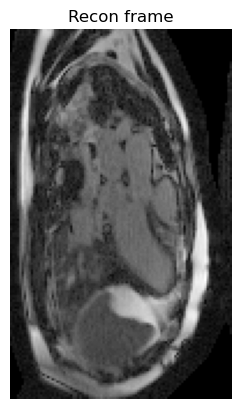


frame  24
SSIM:  0.9795413263676794
NMSE:  -24.190813201962126


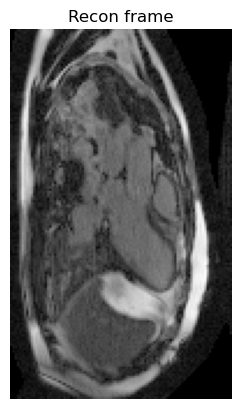


frame  25
SSIM:  0.9786649514853856
NMSE:  -24.017511541398342


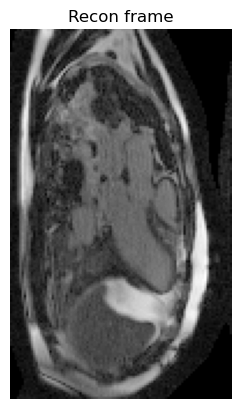


frame  26
SSIM:  0.9801947689602617
NMSE:  -24.348141723072672


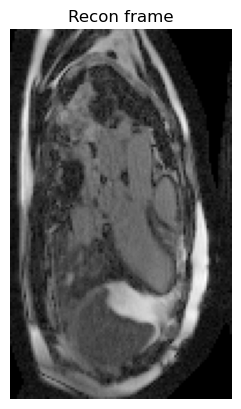


frame  27
SSIM:  0.9789618544910546
NMSE:  -24.201435337235004


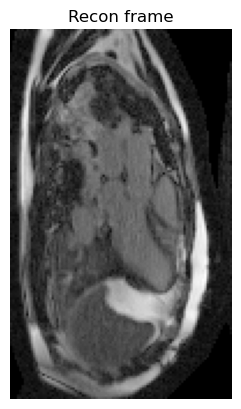


frame  28
SSIM:  0.9790161097152036
NMSE:  -24.37804189549969


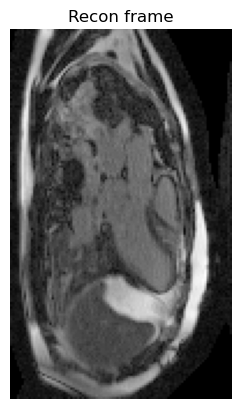


frame  29
SSIM:  0.9791858136879754
NMSE:  -24.455641546059447


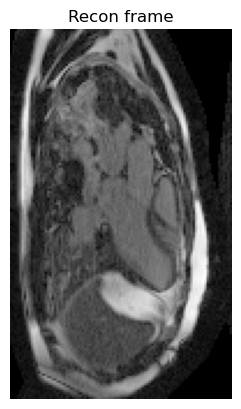


frame  30
SSIM:  0.9784958123663431
NMSE:  -24.26408037697527


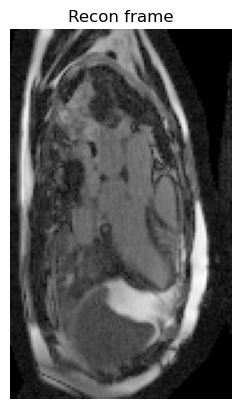


frame  31
SSIM:  0.9804043446728623
NMSE:  -24.67555335266163


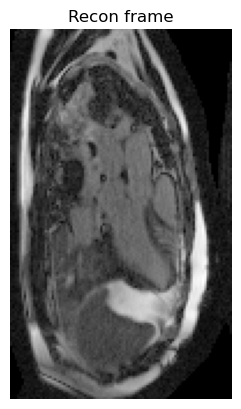


frame  32
SSIM:  0.9802868987033633
NMSE:  -24.623565100127767


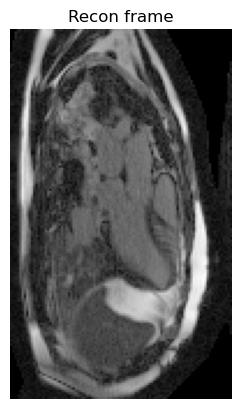

Recon images saved!


In [17]:

xHat_SSDIP = torch.zeros((2*N,n[0],n[1])) # to save
# SSDIP_ksp_sc = np.zeros((1, N))
sen_msk_to = np_to_torch(sen_msk).to(device)
ksp_to = torch.squeeze(np_to_torch(ksp)).to(device)
gt_to = torch.squeeze(np_to_torch(img)).to(device)
net = ExtraDeepUNet(n_channels=2, n_classes=2).to(device)
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
samp_to = torch.squeeze(np_to_torch(samp)).to(device)
sen_maps_c = np_to_torch(sen_c).to(device)
sen_maps = np_to_torch(maps).to(device)

for i in range(N): #N 
    print("\nframe ", i+1)  
    ## noisy kspace
    # ksp_u = torch.zeros(1,Nc,n[0],n[1], dtype=torch.complex64) # complex
    # ksp_gt = torch.zeros(1,1,n[0],n[1], dtype=torch.complex64) # complex
    ksp_u = ksp_to[i,:,:,:] # undersampled kspace
    ## ground truth kspace
    # ksp_gt[0,0,:,:] = np_to_torch(yN[2*i,:,:]) + 1j*np_to_torch(yN[2*i+1,:,:])
    ###
    # gt = torch.randn(1,n[0],n[1]).to(device)
    gt = torch.unsqueeze(gt_to[i,:,:], dim=0)
    ###
    # print(gt.shape, gt.dtype)

    # 2nd optimizer for refernce: flexible w.r.t. LR
    ref = Variable(torch.rand((1,2,n[0],n[1])), requires_grad=True)
    optimizer2 = optim.Adam([ref], lr = 1e-1)

    #net= nn.DataParallel(net).to(device)
    init_weights(net, init_type='normal',init_gain=0.02)


    # data normalization
    with torch.no_grad():
        scale_factor = torch.linalg.norm(net(ref.to(device)))/torch.linalg.norm(gt)
        target_ksp = scale_factor * ksp_u
        # SSDIP_ksp_sc[0,i] = scale_factor
        
        # if sv_SSDIP:
            
            # print("ksp scale saved!", scale_factor.item())
        # print('K-space scaled by: ', scale_factor)

    gt = torch.abs(gt)/torch.max(torch.abs(gt))
        
    # print(gt.shape)
    # plt.imshow(np.squeeze(gt))
    # plt.show()

    mask_from_file = samp_to[i,:,:,:]

    # CUDA:
    
    # mask_from_file = mask_from_file.to(device)
    # avg_ksp = avg_ksp.type(dtype)
    # target_ksp = target_ksp.to(device)
    ref = ref.to(device)
    # net = net.to(device)
    

    # training:
    losses = [] # track loss over iterations
    psnrs = []
    avg_psnrs = []
    exp_weight = .99
    k=3 # noise perturbations

    out_avg = torch.zeros_like(torch.abs(gt)).to(device)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        optimizer2.zero_grad()
        noise_max = torch.max(ref)/2
        random_smoothing_temp = torch.zeros_like(ref).to(device)
        for jj in range(k):
            noise = noise_max * torch.rand(*ref.shape).to(device) # uniform 
        
            net_output = net(ref + noise).squeeze()
            random_smoothing_temp += net_output
        net_output_final = random_smoothing_temp/3
        #print(net_output_final.shape)
        net_output_final = torch.view_as_complex(net_output_final.squeeze().permute(1,2,0).contiguous())
        # print()
        pred_ksp = mps_and_gt_to_ksp(sen_maps_c, net_output_final)
        # print(pred_ksp.size())
        
        loss = torch.linalg.norm(target_ksp - mask_from_file * pred_ksp.squeeze()) \
            + alpha * torch.linalg.norm(ref - net_output_final)
        
        
        loss.backward()
        optimizer.step()
        optimizer2.step()
        with torch.no_grad():
            # out = torch.abs(ksp_and_mps_to_gt(torch.squeeze(pred_ksp), torch.squeeze(sen_maps))).squeeze()
            # out = torch.abs(net_output_final*sen_msk_to).squeeze()
            out = net_output_final*sen_msk_to
            # out /= torch.max(out)
            # # print(out.size(), gt.size())
            # psnr = compute_psnr(np.squeeze(torch_to_np(gt)), torch_to_np(torch.unsqueeze(out, dim=0)))
            # psnrs.append(psnr)

            losses.append(loss.item())

            out_avg = out_avg * exp_weight + out * (1 - exp_weight) # complex
            # print(out_avg.max().item())
            avg_psnr = compute_psnr(np.squeeze(torch_to_np(gt)), np.squeeze(torch_to_np(torch.abs(out_avg)))/float(torch.abs(out_avg).squeeze().max().item()))
            avg_psnrs.append(avg_psnr)
            
            # avg_ksp = avg_ksp * exp_weight + pred_ksp * (1 - exp_weight)
            if PLOT:
                if epoch ==0 or (epoch+1)%(show_every) == 0:
                    print("Iter: ", epoch+1)
                    print("SSIM: ", compute_ssim(np.squeeze(torch_to_np(gt)), np.squeeze(torch_to_np(torch.abs(out_avg)))/float(torch.abs(out_avg).squeeze().max().item())))
                    print("NMSE: ", compute_nmse(gt.to(device), torch.abs(out_avg).squeeze()/float(torch.abs(out_avg).squeeze().max().item())).item())
                    plt.figure(figsize=(6,8))
                    plt.subplot(131)
                    plt.imshow(np.squeeze(torch_to_np(torch.abs(out_avg)/float(torch.abs(out_avg).max().item())))**gm, cmap='gray')
                    plt.title('Sliding Average\nPSNR = ' + str(round(avg_psnr, 2)))
                    plt.axis('OFF')
                
                    plt.subplot(132)
                    plt.imshow(np.squeeze(np.abs(torch_to_np(gt)))**gm, cmap='gray')
                    plt.title('Ground Truth')
                    #plt.colorbar()
                    plt.axis('OFF')
                
                    plt.show()
    if PLOT:
            # plot loss over iterations:
        plt.figure()
        plt.plot(np.log10(losses))
        plt.title("Loss VS iterations")
        plt.show()
            # plt.


    # ## hard data consistency:
    # pred_img = out_avg
    # ksp_ac = mask_from_file * target_ksp 
    # ksp_es = (1-mask_from_file) * (mps_and_gt_to_ksp(sen_maps, pred_img))
    # ksp_cor = ksp_ac + ksp_es

    # ksp to image:
    # img_out = ksp_and_mps_to_gt(torch.squeeze(ksp_cor), torch.squeeze(sen_maps)) *sen_msk_to
    # print()
    img_out = out_avg
    img_np = np.squeeze(np.abs(torch_to_np(torch.unsqueeze(img_out,dim=0))))
    img_tor = torch.abs(torch.squeeze(img_out))
    # print(img_np.shape, np.squeeze(torch_to_np(gt)).shape)

    # print("After Hard DC:")
    print("SSIM: ", compute_ssim(np.squeeze(torch_to_np(gt)), img_np/np.max(img_np)))
    # print("warning 1")
    print("NMSE: ", compute_nmse(gt.to(device), img_tor/float(img_tor.max().item())).item())
    # print("warning 2")
    # print(img.shape)

    # fig, axes = plt.subplots(1,3)
    plt.imshow((img_np/np.max(img_np))**gm, cmap='gray')
    plt.title("Recon frame")
    plt.axis("OFF")
    plt.show()


    ###
    
    ###

    xHat = img_out
    xHat_SSDIP[2*i,:,:] = xHat.real
    xHat_SSDIP[2*i+1,:,:] = xHat.imag

if sv_SSDIP:
    np.save(data_path_r + 'xHat_SSDIP.npy', torch_to_np(torch.unsqueeze(xHat_SSDIP,dim=0)))
    print("Recon images saved!")
    # np.save(data_load + 'SSDIP_ksp_sc.npy', SSDIP_ksp_sc)
           